In [56]:
import json
import requests
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from PIL import Image
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel

# Directories
img_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/'
ann_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/'
train_annotation_path = f'{ann_dir}train.json'
val_annotation_path = f'{ann_dir}val.json'
test_annotation_path = f'{ann_dir}test.json'

# Device configuration
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
# Load annotation data
def load_annotations(url):
    response = requests.get(url, allow_redirects=True)
    return response.json()

train_data = load_annotations(train_annotation_path)
val_data = load_annotations(val_annotation_path)
test_data = load_annotations(test_annotation_path)

print(f'Train set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')


mps
Train set size: 20523
Validation set size: 4319
Test set size: 8000


In [57]:
import random

def train_val_split(data, size):
    data = list(data)

    class_1 = [s for s in data if s['answerable'] == 1]
    class_0 = [s for s in data if s['answerable'] == 0]
    print(f'Class 1: {len(class_1)}', f'Class 0: {len(class_0)}')
    num_samples = min(size // 2, len(class_1), len(class_0))

    sampled_data = random.sample(class_1, num_samples) + random.sample(class_0, num_samples)
    random.shuffle(sampled_data)

    return sampled_data

In [55]:

train_subset = train_val_split(train_data,18000)
val_subset = train_val_split(val_data,300)

test_subset = test_data[:100]


Class 1: 14991 Class 0: 5532
Class 1: 2934 Class 0: 1385


In [50]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load Word2Vec model (50D embeddings)
word2vec_model = api.load("glove-wiki-gigaword-50")

# Initialize text preprocessing tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_text_embedding(text):
    """Converts input text into a 50D Word2Vec vector after preprocessing."""
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]  # Lemmatize, remove stopwords and non-alphanumeric tokens
    word_vectors = [word2vec_model[w] for w in words if w in word2vec_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(50)

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize without center cropping
    transforms.RandomHorizontalFlip(p=0.5),  # Augment: Flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augment: Adjust colors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])

# Load images and convert to tensors
folder_path = "/Users/darshanvijayaraghavan/Downloads/train"
image_tensors = []
question_embeddings = []

for sample in train_subset:
    # Load and transform image
    image_path = os.path.join(folder_path, sample['image'])
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    image_tensors.append(img_tensor)

    # Convert question to Word2Vec embedding
    question_embeddings.append(get_text_embedding(sample['question']))

# Convert lists to PyTorch tensors
image_tensors = torch.stack(image_tensors).to(device)
question_tensors = torch.tensor(question_embeddings, dtype=torch.float32).to(device)

print(f'Train images shape: {image_tensors.shape}')
print(f'Train question embeddings shape: {question_tensors.shape}')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train images shape: torch.Size([11064, 3, 128, 128])
Train question embeddings shape: torch.Size([11064, 50])


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class VQAModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=1, num_heads=2, dropout_rate=0.2):
        super(VQAModel, self).__init__()

        # Image feature extraction (ResNet34 backbone)
        self.cnn = models.resnet34(pretrained=True)
        for param in list(self.cnn.parameters())[:-8]:
            param.requires_grad = False
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, hidden_dim)

        # Text feature extraction
        self.text_embedding = nn.Sequential(
            nn.Linear(50, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Multi-head Attention
        self.img_to_text_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.text_to_img_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Normalization layers
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Gated Fusion Mechanism
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, text):
        # Image feature extraction
        img_features = self.cnn(image)  # [batch_size, hidden_dim]

        # Text feature extraction
        text_features = self.text_embedding(text)  # [batch_size, hidden_dim]

        # Prepare features for attention
        img_features_attn = img_features.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        text_features_attn = text_features.unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Cross-modal attention
        attended_text, _ = self.img_to_text_attention(
            query=img_features_attn,
            key=text_features_attn,
            value=text_features_attn
        )
        attended_img, _ = self.text_to_img_attention(
            query=text_features_attn,
            key=img_features_attn,
            value=img_features_attn
        )

        # Apply normalization
        attended_text = self.norm1(attended_text).squeeze(1)  # [batch_size, hidden_dim]
        attended_img = self.norm2(attended_img).squeeze(1)  # [batch_size, hidden_dim]

        # Gated fusion mechanism
        concat_features = torch.cat([attended_text, attended_img], dim=1)  # [batch_size, hidden_dim * 2]
        gate_value = self.gate(concat_features)
        fused_features = gate_value * attended_text + (1 - gate_value) * attended_img  # [batch_size, hidden_dim]

        # Classification
        logits = self.classifier(fused_features)  # [batch_size, num_classes]

        return logits


/var/folders/5x/_42ylnsd23vdf9czqb289bn40000gn/T/ipykernel_20108/3937859286.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets, dtype=torch.float32)


Epoch [1/10], Loss: 0.6574, Accuracy: 0.6126, Val Loss: 0.6280, Val Accuracy: 0.6533
Best model saved with validation accuracy: 0.6533
Epoch [2/10], Loss: 0.5891, Accuracy: 0.6889, Val Loss: 0.5716, Val Accuracy: 0.7333
Best model saved with validation accuracy: 0.7333
Epoch [3/10], Loss: 0.5532, Accuracy: 0.7146, Val Loss: 0.5586, Val Accuracy: 0.7233
Epoch [4/10], Loss: 0.5306, Accuracy: 0.7317, Val Loss: 0.5603, Val Accuracy: 0.7267
Epoch [5/10], Loss: 0.5129, Accuracy: 0.7514, Val Loss: 0.5582, Val Accuracy: 0.7167
Epoch [6/10], Loss: 0.5029, Accuracy: 0.7526, Val Loss: 0.5487, Val Accuracy: 0.7200
Epoch [7/10], Loss: 0.4880, Accuracy: 0.7625, Val Loss: 0.5560, Val Accuracy: 0.7233
Epoch [8/10], Loss: 0.4720, Accuracy: 0.7758, Val Loss: 0.5565, Val Accuracy: 0.7233
Epoch [9/10], Loss: 0.4580, Accuracy: 0.7830, Val Loss: 0.5483, Val Accuracy: 0.7200
Epoch [10/10], Loss: 0.4419, Accuracy: 0.7955, Val Loss: 0.5476, Val Accuracy: 0.7300


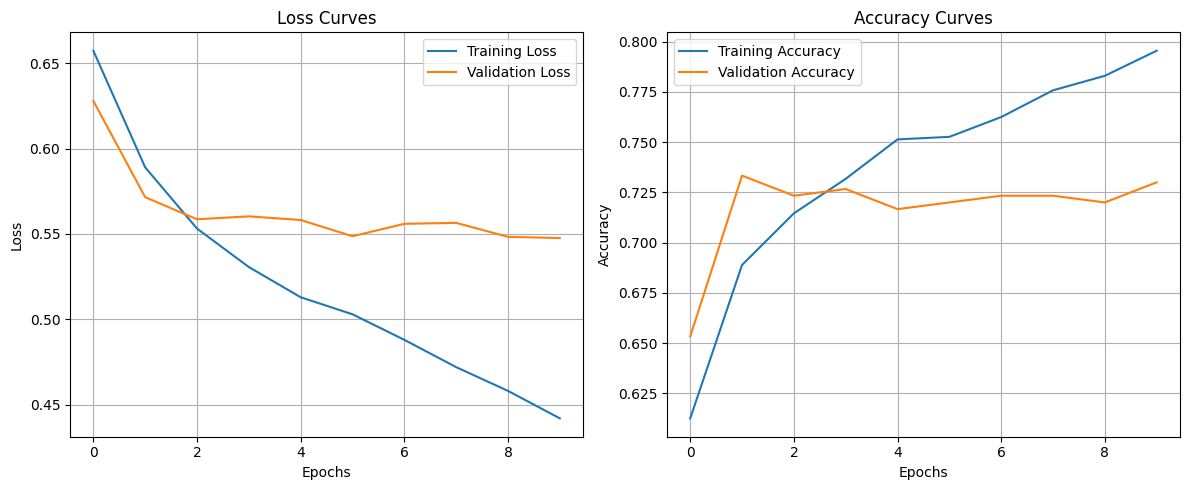


Loaded best model from epoch 2 with:
  - Validation Accuracy: 0.7333
  - Validation Loss: 0.5716
  - Training Accuracy: 0.6889
  - Training Loss: 0.5891


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

# Model initialization
model = VQAModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, weight_decay=1e-5, momentum=0.90)

# Define Dataset class
class VQADataset(Dataset):
    def __init__(self, image_tensors, question_tensors, targets):
        self.image_tensors = image_tensors
        self.question_tensors = question_tensors
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.question_tensors[idx], self.targets[idx]

# Create training dataset & DataLoader
batch_size = 32
train_dataset = VQADataset(image_tensors, question_tensors, [sample['answerable'] for sample in train_subset])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load validation dataset
folder_path = "/Users/darshanvijayaraghavan/Downloads/val"
val_image_tensors = torch.stack([transform(Image.open(os.path.join(folder_path, sample['image'])).convert("RGB")) for sample in val_subset]).to(device)
val_question_tensors = torch.tensor([get_text_embedding(sample['question']) for sample in val_subset], dtype=torch.float32).to(device)
val_targets = torch.tensor([sample['answerable'] for sample in val_subset], dtype=torch.float32).to(device)
val_dataset = VQADataset(val_image_tensors, val_question_tensors, val_targets)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
best_val_accuracy = 0.0
best_model_path = 'best_vqa_model.pth'

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    for images, questions, targets in train_loader:
        images, questions, targets = images.to(device), questions.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, questions).squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total

    # Store training metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, questions, targets in val_loader:
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)
            outputs = model(images, questions).squeeze(1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Store validation metrics
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")

    # Save best model based on validation accuracy
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_epoch_accuracy,
            'val_loss': val_epoch_loss,
            'train_accuracy': epoch_accuracy,
            'train_loss': epoch_loss
        }, best_model_path)
        print(f"Best model saved with validation accuracy: {best_val_accuracy:.4f}")

# Plot training and validation curves
plt.figure(figsize=(12, 5))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('vqa_training_curves.png')
plt.show()

# Load best model and evaluate
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1} with:")
print(f"  - Validation Accuracy: {checkpoint['val_accuracy']:.4f}")
print(f"  - Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  - Training Accuracy: {checkpoint['train_accuracy']:.4f}")
print(f"  - Training Loss: {checkpoint['train_loss']:.4f}")



Training with params: {'batch_size': 32, 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 1e-05}
Epoch [1/10], Loss: 0.5844, Accuracy: 0.6787, Val Loss: 0.5476, Val Accuracy: 0.7333
Epoch [2/10], Loss: 0.5059, Accuracy: 0.7530, Val Loss: 0.5082, Val Accuracy: 0.7433
Epoch [3/10], Loss: 0.4476, Accuracy: 0.7899, Val Loss: 0.5407, Val Accuracy: 0.7567
Epoch [4/10], Loss: 0.3892, Accuracy: 0.8241, Val Loss: 0.6033, Val Accuracy: 0.6933
Epoch [5/10], Loss: 0.3234, Accuracy: 0.8624, Val Loss: 0.6788, Val Accuracy: 0.7100
Epoch [6/10], Loss: 0.2594, Accuracy: 0.8928, Val Loss: 0.6115, Val Accuracy: 0.7333
Epoch [7/10], Loss: 0.2016, Accuracy: 0.9201, Val Loss: 0.8512, Val Accuracy: 0.7367
Epoch [8/10], Loss: 0.1602, Accuracy: 0.9393, Val Loss: 0.7841, Val Accuracy: 0.7100
Epoch [9/10], Loss: 0.1368, Accuracy: 0.9527, Val Loss: 0.7969, Val Accuracy: 0.7400
Epoch [10/10], Loss: 0.1153, Accuracy: 0.9597, Val Loss: 1.0063, Val Accuracy: 0.7100

Training with params: {'batch_size': 32, 'lr': 

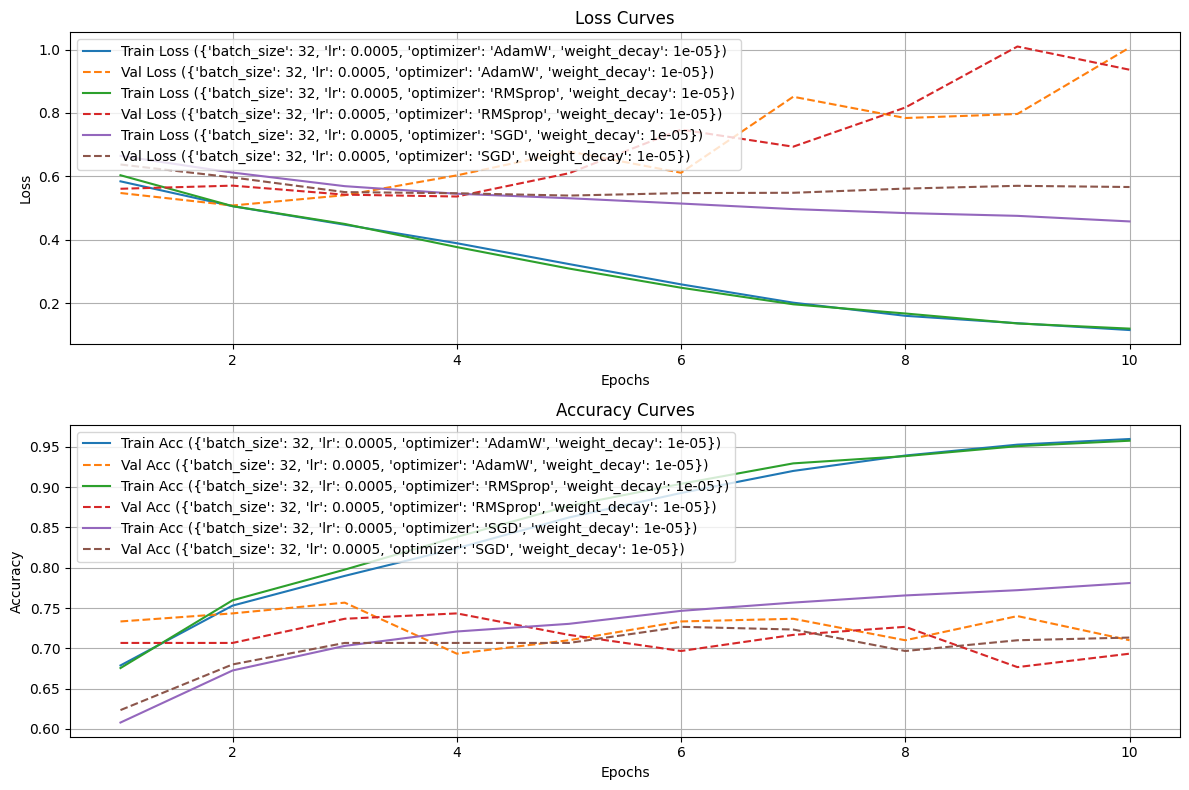

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader

# Define hyperparameter grid with more variations
param_grid = {
    'lr': [0.0005],
    'weight_decay': [1e-5],
    'batch_size': [32],
    'optimizer': ['AdamW', 'RMSprop', 'SGD']
}

# Fixed number of epochs
num_epochs = 10

# Tracking best parameters
best_params = None
best_val_loss = float('inf')

# Store all loss and accuracy curves
history = {}

# Iterate over all hyperparameter combinations
for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")

    # Set hyperparameters
    batch_size = params['batch_size']

    # Create DataLoader with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = VQAModel().to(device)

    # Define loss function
    criterion = nn.BCEWithLogitsLoss()

    # Select optimizer
    if params['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'], momentum=0.90)

    # Store training history
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, questions, targets in train_loader:
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions).squeeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, questions, targets in val_loader:
                images, questions, targets = images.to(device), questions.to(device), targets.to(device)
                outputs = model(images, questions).squeeze(1)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_accuracy = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")

        # Track best parameters based on validation loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_params = params

    # Store results for visualization
    history[str(params)] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

print(f"\nBest Hyperparameters: {best_params} with Validation Loss: {best_val_loss:.4f}")

# Plot training and validation curves
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for key, values in history.items():
    axes[0].plot(range(1, num_epochs+1), values['train_losses'], label=f"Train Loss ({key})")
    axes[0].plot(range(1, num_epochs+1), values['val_losses'], label=f"Val Loss ({key})", linestyle="dashed")

    axes[1].plot(range(1, num_epochs+1), values['train_accuracies'], label=f"Train Acc ({key})")
    axes[1].plot(range(1, num_epochs+1), values['val_accuracies'], label=f"Val Acc ({key})", linestyle="dashed")

axes[0].set_title("Loss Curves")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Accuracy Curves")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


In [53]:
# Define paths
test_folder_path = "/Users/darshanvijayaraghavan/Downloads/test"
output_file = "Darshan_Vijayaraghavan_challenge1.pkl"  # Replace with your actual name

# Prepare test image tensors
test_image_tensors = torch.stack([
    transform(Image.open(os.path.join(test_folder_path, sample['image'])).convert("RGB"))
    for sample in test_subset
]).to(device)

# Prepare test question tensors
test_question_tensors = torch.tensor([
    get_text_embedding(sample['question'])
    for sample in test_subset
], dtype=torch.float32).to(device)


model.load_state_dict(checkpoint['model_state_dict'])

# Model inference
model.eval()
with torch.no_grad():
    outputs = model(test_image_tensors, test_question_tensors).squeeze(1)
    predictions = (torch.sigmoid(outputs) > 0.5).long()  # Convert to binary (0 or 1)

# Ensure tensor is 1-dimensional
predictions = predictions.view(-1)
print(predictions)
# Save predictions as a .pkl file
torch.save(predictions, output_file)

print(f"Predictions saved to {output_file}")


tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0], device='mps:0')
Predictions saved to Darshan_Vijayaraghavan_challenge1.pkl
